**The Data Science Method**


1.   [Problem Identification](https://medium.com/@aiden.dataminer/the-data-science-method-problem-identification-6ffcda1e5152)

2.   [Data Wrangling](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-data-collection-organization-and-definitions-d19b6ff141c4)
  * Data Collection - Collected data from wikipedia and quandl wiki price dataset. The wikipedia showed us the currect S&P 500 companies and used their ticker symbols to query quandl wiki prices.
  * Data Organization - Done using cookiecutter
  * Data Definition
  * Data Cleaning - The S&P 500 data from quandls wiki price is clean and ready for analysis use but has lost its support from Quandl community as of April 11, 2018. So we will use this dataset to setup the protfolio optimizer with proof of concept then use a different data source later for cost efficiencies.

3.   [Exploratory Data Analysis](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-exploratory-data-analysis-bc84d4d8d3f9)
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   [Pre-processing and Training Data Development](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-pre-processing-and-training-data-development-fd2d75182967)
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
5.   [**Modeling**](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-modeling-56b4233cad1b)
  * Create dummy or indicator features for categorical variable
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

First, loads the needed packages and modules into Python. Then loads the data into a pandas dataframe for ease of use.

In [1]:
#load python packages
import os
import random
import numpy as np
import pandas as pd
import pypfopt
import pickle

# from scipy.stats import norm

import datetime as dt
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
random.seed(42)

In [3]:
# prints current directory
current_dir = os.getcwd()
print("Current Directory: ")
print(current_dir)

Current Directory: 
/Users/jb/Development/courses/springboard/ds/Assignments/Portfolio-Optimization/portopt/notebooks/exploratory


In [4]:
# prints parent directory
project_dir = os.path.abspath(os.path.join(os.path.join(current_dir, os.pardir), os.pardir))
print("Parent Directory: ")
print(project_dir)

Parent Directory: 
/Users/jb/Development/courses/springboard/ds/Assignments/Portfolio-Optimization/portopt


In [5]:
print(os.listdir())

['3.0-jujbates-S&P500-PO_eda.ipynb', '.DS_Store', '5.0-jujbates-S&P500-PO_modeling.ipynb', '4.0-jujbates-S&P500-PO_pre-processing_and_training_data_development.ipynb', '6.0-jujbates-S&P500-PO_report_results-Copy1.ipynb', '6.0-jujbates-S&P500-PO_report_results.ipynb', '.ipynb_checkpoints', '1.0-jujbates-S&P500-PO_problem_identification.ipynb', '2.0-jujbates-S&P500-PO_data_wrangling.ipynb']


In [6]:
plt.style.use('dark_background')
c = ['white', 'springgreen', 'fuchsia', 'lightcoral', 'red'] # Color
s = [24, 20, 16, 12]  # Size
w = [0.75, 1, 1.25, 1.50] # Line Width
ga = 0.10 # Grid Alpha

In [7]:
sp500_adj_close_df = pd.read_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_adj_close_interim.csv', index_col=['date'])
sp500_index_adj_close_df = pd.read_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_index_adj_close_interim.csv', index_col=['date'])

rand_one_year_window_sym_50_df = pd.read_csv(project_dir + '/data/interim/'+ 'sp500_rand_one_year_window_sym_50_interim.csv', index_col=['index'])
rand_one_year_window_sp500_index_df = pd.read_csv(project_dir + '/data/interim/'+ 'sp500_rand_one_year_window_sp500_index_interim.csv', index_col=['index'])

In [8]:
sp500_adj_close_df.index = pd.to_datetime(sp500_adj_close_df.index)
sp500_adj_close_df.index

DatetimeIndex(['1999-01-04', '1999-01-05', '1999-01-06', '1999-01-07',
               '1999-01-08', '1999-01-11', '1999-01-12', '1999-01-13',
               '1999-01-14', '1999-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5283, freq=None)

In [9]:
sp500_index_adj_close_df.index = pd.to_datetime(sp500_adj_close_df.index)
sp500_index_adj_close_df.index

DatetimeIndex(['1999-01-04', '1999-01-05', '1999-01-06', '1999-01-07',
               '1999-01-08', '1999-01-11', '1999-01-12', '1999-01-13',
               '1999-01-14', '1999-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5283, freq=None)

## Hypothesis formulation
#### Our Null hypothesis is just:

*Hnull:* the observed difference in the mean cumulative return of a portfolio generated with optimizated max sharpe ratio asset weights from 1 year of S&P 500 adjusted close and an equally weighted asset portolio from S&P 500 is due to chance (and thus not due to the optimizated max sharpe ratio asset weights from 1 year of S&P 500 adjusted close).


*Halternative:* the observed difference in the mean cumulative return of both portfolios is not due to chance (and is actually due to the optimizated max sharpe ratio asset weights from 1 year of S&P 500 adjusted close)

We're also going to pick a significance level of 0.05.

In [10]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import objective_functions
from pypfopt import expected_returns
from pypfopt import plotting

def optimize_ef_max_sharpe_ratio(df):
    # Calculate expected returns and sample covariance
    mu = expected_returns.ema_historical_return(df)
    S = risk_models.semicovariance(df)

    # Optimise for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    
    # Expected return, Volatility, and the Sharpe ratio
    er, vol, sr = ef.portfolio_performance()
    return cleaned_weights, er, vol, sr


    
def get_daily_portfolio_values(prices, allocs, sv):
    """ 
    Get the daily portfolio values.

    To get the daily values the function normalizes portfolio's adjusted closing prices, 
    allocates the normalized symbol by the portfolio allocations, scales to the the portfolio's 
    psition values with the start values and finally sums by each day.
  
    Parameters: 
    prices (dataFrame): Adjusted closing prices for symbols in portfolio  
    allocs (list): A list of 2 or more allocations to the stocks, must sum to 1.0
    sv (float): Start value of the portfolio
    

    Returns: 
    dataFrame: Portfolio values
  
    """
    normed_price = prices / prices.iloc[0]  # Normalize Adj Close Prices
    alloced_price = normed_price * allocs  # Allocated Normalize Adj Close Prices
    pos_val = alloced_price * sv  # Position Values
    return pos_val.sum(axis=1)  # Portfolio Values





In [11]:
def cumulative_return(df):
    return (df.iloc[-1] / df.iloc[0]) - 1

def daily_returns(df):
    return df.pct_change() * 100

def sharpe_ratio(adr, sddr, rfr=0):
    return (adr - rfr) / sddr 

In [12]:

def plot_portfolio_window_performance(pv_df, p_df):
        # Build plot figure
        fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 16))
        ax1.set_title(f"Portfolio Values", fontsize=s[1])
        ax1.set_xlabel(f"Date", fontsize=s[2])
        ax1.set_ylabel(f"Price", fontsize=s[2])
        
        # Plot the results
        pv_df.plot(kind='line', ax=ax1, legend=None)
        
        ax2.set_title(f"Cumulative Return Distribution", fontsize=s[1])
        ax2.set_xlabel(f"Cumulative Return (%)", fontsize=s[2])
        ax2.set_ylabel(f"Frequence", fontsize=s[2])
        
        # Plot the results
        sns.histplot(data=p_df, x='Cumulative Return', bins=30, ax=ax2)

        plt.show()

def portfolio_window_performance(prices, window_sym_df, projection_window_days=365, optimize=True, plot_flag=False):
    pv_df = pd.DataFrame(index=prices.index)
    dr_df = pd.DataFrame(index=prices.index)
    performance_df = pd.DataFrame(index=window_sym_df.columns)
    performance_df['Cumulative Return'] = 0
    for i in window_sym_df:
        sv = 1
        ii = i.split('-->')
        sd = dt.datetime.strptime(ii[0], '%Y-%m-%d %H:%M:%S') 
        ed = dt.datetime.strptime(ii[1], '%Y-%m-%d %H:%M:%S')   
        dd = dt.timedelta(days=projection_window_days)
        
        sym_list = window_sym_df[i].to_list()
        w_prices = prices.loc[sd:ed, sym_list].copy(deep=True)
        if optimize:
            cleaned_weights, er, vol, sr = optimize_ef_max_sharpe_ratio(w_prices)
            allocs = pd.DataFrame({'cleaned_weights': cleaned_weights}, index=w_prices.columns)['cleaned_weights'].to_list()
        else:
            allocs = 1  
        e_price = prices.loc[ed:ed+dd, sym_list]

        pv = get_daily_portfolio_values(e_price, allocs, sv=sv)
        pv_df.insert(0, i, pd.Series(pv, index=e_price.index))
        
        cr = cumulative_return(pv_df.loc[ed:ed+dd, i])            
        performance_df.loc[i, 'Cumulative Return'] = cr * 100

    pv = get_daily_portfolio_values(e_price, allocs, sv=sv)
    
    if plot_flag:
        plot_portfolio_window_performance(pv_df, performance_df)
        
       
    return performance_df


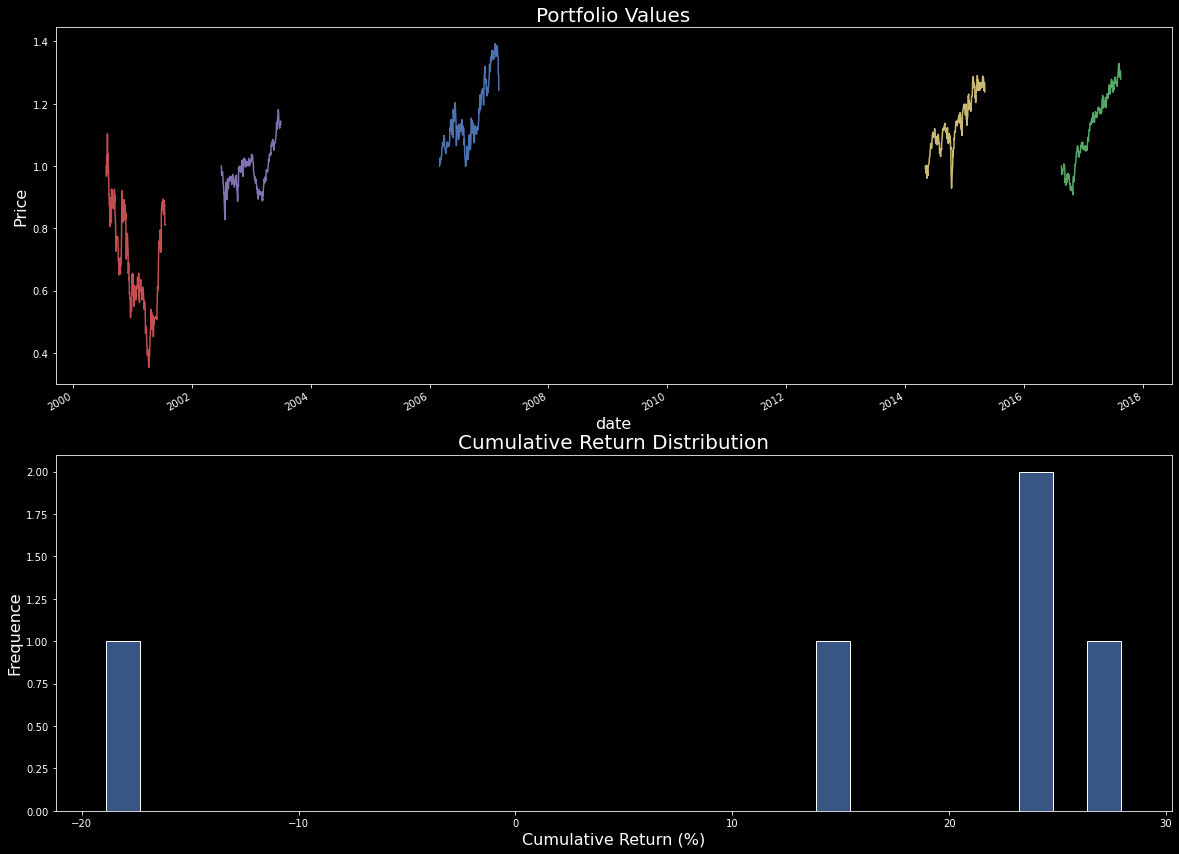

In [13]:
opt_port_performance_df = portfolio_window_performance(sp500_adj_close_df, rand_one_year_window_sym_50_df, projection_window_days=365, plot_flag=True)

In [14]:
import random

def get_random_date_ranges(start_date='1999-01-01', end_date='2019-12-31', range_window=365, evaluation_window=365, n_ranges=3):
    random_date_ranges = []

    range_window_dd = dt.timedelta(days=range_window)
    evaluation_window_dd = dt.timedelta(days=evaluation_window)

    start_date =  dt.datetime.strptime('1999-01-01', '%Y-%m-%d') 
    end_date =  dt.datetime.strptime('2019-12-31', '%Y-%m-%d') - (range_window_dd + evaluation_window_dd)    
    
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days    
    
    for i in range(n_ranges):
        random_number_of_days = random.randrange(days_between_dates)        
        random_start_date = start_date + dt.timedelta(days=random_number_of_days)
        
        random_end_date = random_start_date + range_window_dd
        random_date_ranges.append((random_start_date, random_end_date))
    return random_date_ranges


def get_top_20_symbols_with_sharpe_ratio(date_ranges, df):
    sym_df = pd.DataFrame({})
    for sd, ed in date_ranges:
        prices = df.copy(deep=True).loc[sd : ed]
        dr = daily_returns(prices)
        sr = sharpe_ratio(dr.mean(), dr.std(), rfr=0)
        idx = str(sd) + '-->' + str(ed)
        if len(sr) == 1 and sr.index[0] == '^GSPC':
            sym_df[idx] = sr.index.tolist()
        else:
            sym_df[idx] = sr.sort_values(ascending=False)[:20].index.tolist()

    return sym_df

In [ ]:
pickle_off = open(project_dir + '/data/results/' + 'btsp_opt_port_stats.pkl','rb')
btsp_opt_port_stats = pickle.load(pickle_off)

pickle_off = open(project_dir + '/data/results/' + 'btsp_sp500_index_stats.pkl','rb')
btsp_sp500_index_stats = pickle.load(pickle_off)


In [ ]:
pickle_off = open(project_dir + '/data/results/' + 'gbsp_opt_port_stats.pkl','rb')
gbsp_opt_port_stats = pickle.load(pickle_off)

pickle_off = open(project_dir + '/data/results/' + 'gbsp_sp500_index_stats.pkl','rb')
gbsp_sp500_index_stats = pickle.load(pickle_off)


In [15]:
stocks = sp500_adj_close_df.loc['2016-01-01':'2018-01-01',].dropna(axis=1).copy()
stocks

,AMCR,HBAN,NWS,NWSA,HPE,PBCT,NLOK,F,HST,HPQ,...,ISRG,CMG,MTD,AZO,GOOG,GOOGL,AIG,AMZN,BKNG,NVR
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,7.753601,8.795252,12.679182,12.225597,7.664462,12.645448,8.933861,10.590919,12.597794,9.785186,...,182.463333,448.809998,329.339996,735.479980,741.840027,759.440002,52.719463,636.989990,1245.369995,1555.660034
2016-01-05,7.584871,8.811694,12.159772,11.818386,7.613805,12.637430,8.951012,10.401392,12.788918,9.877976,...,183.986664,449.029999,331.380005,738.859985,742.580017,761.530029,52.902676,633.789978,1210.689941,1594.089966
2016-01-06,7.584871,8.671956,12.271076,11.762856,7.497294,12.517146,8.938149,9.938939,12.523003,9.523685,...,184.413330,426.670013,324.739990,729.200012,743.619995,759.330017,52.126232,632.650024,1196.709961,1587.060059
2016-01-07,7.584871,8.408920,12.067021,11.494468,6.945126,12.228475,8.788109,9.628110,12.090889,9.085038,...,178.966660,416.000000,315.730011,735.960022,726.390015,741.000000,50.878693,607.940002,1167.189941,1552.319946
2016-01-08,7.584871,8.260962,12.067021,11.642544,6.859009,11.987916,8.783823,9.506811,12.057650,8.924764,...,178.846664,413.290009,313.929993,712.059998,714.469971,730.909973,50.119698,607.049988,1136.959961,1541.420044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,9.825862,12.816978,16.073940,15.694941,13.312966,16.465670,15.519702,10.773566,18.213522,19.342567,...,363.160004,295.230011,614.770020,710.090027,1060.119995,1068.859985,54.016155,1168.359985,1775.260010,3480.000000
2017-12-26,10.260633,12.686901,15.882583,15.589797,13.340117,16.422157,15.470380,10.790694,18.249699,19.315273,...,365.829987,295.519989,613.530029,714.479980,1056.739990,1065.849976,54.125446,1176.760010,1755.319946,3471.000000
2017-12-27,10.260633,12.652212,15.930422,15.532447,13.276766,16.343832,15.590944,10.705053,18.222567,19.351664,...,368.089996,295.420013,615.929993,707.000000,1049.369995,1060.199951,54.225628,1182.260010,1757.880005,3462.000000


In [16]:

    
stock_pv_df = pd.DataFrame(index=stocks.index)
index_pv_df = pd.DataFrame(index=stocks.index)

stock_performance_df = pd.DataFrame(index=stocks.columns)
stock_performance_df['Cumulative Return'] = 0

index_performance_df = pd.DataFrame(index=stocks.columns)
index_performance_df['Cumulative Return'] = 0

sv = 1

sd = dt.datetime.strptime('2016-01-01', '%Y-%m-%d')
ed = dt.datetime.strptime('2016-12-31', '%Y-%m-%d')
projection_window_days=365
dd = dt.timedelta(days=projection_window_days)
dd1 = dt.timedelta(days=1)
date_range = [(sd, ed)]
print(date_range)

stock_one_year_window_sym_20_df = get_top_20_symbols_with_sharpe_ratio(date_range, stocks)
stock_sym_list = stock_one_year_window_sym_20_df.iloc[:,0].to_list()

index_one_year_window_sym_20_df = get_top_20_symbols_with_sharpe_ratio(date_range, sp500_index_adj_close_df)
index_sym_list = index_one_year_window_sym_20_df.iloc[:,0].to_list()

# print(stock_sym_list)
# print(index_sym_list)


w_stock_prices = stocks.loc[sd:ed, stock_sym_list].copy(deep=True)
w_index_prices = sp500_index_adj_close_df.loc[sd:ed, index_sym_list].copy(deep=True)


# print(w_stock_prices)
# print(w_index_prices)


# Calculate expected returns and sample covariance
mu = expected_returns.ema_historical_return(w_stock_prices)
S = risk_models.semicovariance(w_stock_prices)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
stock_raw_weights = ef.max_sharpe()
stock_cleaned_weights = ef.clean_weights()

# Expected return, Volatility, and the Sharpe ratio
stock_er, stock_vol, stock_sr = ef.portfolio_performance()

print(stock_er, stock_vol, stock_sr)



print(stock_cleaned_weights)

[(datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2016, 12, 31, 0, 0))]
3.0200133604022947 0.1564760959417863 19.172342857521112
OrderedDict([('NVDA', 0.55908), ('WM', 0.0), ('RSG', 0.0), ('OKE', 0.0), ('PWR', 0.0), ('IDXX', 0.0), ('AMD', 0.1909), ('EVRG', 0.2412), ('AMAT', 0.0), ('ITW', 0.0), ('CINF', 0.0), ('WST', 0.0), ('T', 0.0), ('CPRT', 0.0), ('UNH', 0.0), ('HII', 0.00883), ('CMI', 0.0), ('PH', 0.0), ('APH', 0.0), ('XYL', 0.0)])


In [17]:
mu

NVDA    3.391610
WM      0.388807
RSG     0.382105
OKE     1.508992
PWR     0.922452
IDXX    0.659419
AMD     5.489607
EVRG    0.295068
AMAT    0.856087
ITW     0.360070
CINF    0.305803
WST     0.474167
T       0.288412
CPRT    0.470022
UNH     0.446816
HII     0.533916
CMI     0.563287
PH      0.530590
APH     0.335590
XYL     0.330186
Name: 2016-12-30 00:00:00, dtype: float64

In [18]:
S

,NVDA,WM,RSG,OKE,PWR,IDXX,AMD,EVRG,AMAT,ITW,CINF,WST,T,CPRT,UNH,HII,CMI,PH,APH,XYL
NVDA,0.037019,0.005040,0.004348,0.013876,0.009747,0.010613,0.034838,0.000519,0.023009,0.009132,0.005502,0.007544,0.002776,0.008766,0.007041,0.005140,0.010149,0.009578,0.010790,0.011855
WM,0.005040,0.005916,0.005012,0.003847,0.001513,0.003737,0.006224,0.001164,0.004124,0.002910,0.003928,0.003017,0.002615,0.003141,0.002898,0.002598,0.003035,0.002109,0.002537,0.003373
RSG,0.004348,0.005012,0.007424,0.003650,0.002131,0.003495,0.004639,0.001481,0.003806,0.002689,0.003997,0.003409,0.002667,0.003305,0.002344,0.002258,0.002892,0.002993,0.002227,0.003493
OKE,0.013876,0.003847,0.003650,0.065033,0.014873,0.013236,0.030363,0.002452,0.016731,0.007706,0.005560,0.006254,0.005098,0.007426,0.005435,0.006081,0.010029,0.011205,0.010276,0.009727
PWR,0.009747,0.001513,0.002131,0.014873,0.027540,0.007094,0.017584,0.000491,0.009879,0.007675,0.003852,0.004901,0.000946,0.005779,0.004147,0.005681,0.009800,0.010673,0.007314,0.008406
IDXX,0.010613,0.003737,0.003495,0.013236,0.007094,0.016200,0.014461,0.000819,0.010343,0.005985,0.005815,0.008138,0.003143,0.004886,0.005270,0.003703,0.006498,0.006168,0.006422,0.006647
AMD,0.034838,0.006224,0.004639,0.030363,0.017584,0.014461,0.129412,0.001669,0.032477,0.012566,0.010518,0.009321,0.006629,0.016384,0.007878,0.006359,0.015599,0.015672,0.018449,0.015639
EVRG,0.000519,0.001164,0.001481,0.002452,0.000491,0.000819,0.001669,0.006790,0.000607,0.000678,0.001259,0.000453,0.001207,0.000944,0.000686,-0.000146,-0.000094,0.000462,0.000626,0.000310
AMAT,0.023009,0.004124,0.003806,0.016731,0.009879,0.010343,0.032477,0.000607,0.026381,0.008702,0.005819,0.009207,0.001690,0.008124,0.006305,0.004653,0.010126,0.010076,0.012231,0.010529
ITW,0.009132,0.002910,0.002689,0.007706,0.007675,0.005985,0.012566,0.000678,0.008702,0.010277,0.005668,0.005475,0.002580,0.005989,0.003818,0.004218,0.010459,0.009985,0.007136,0.008431


In [19]:
cov_matrix = S.copy()

In [20]:
if not isinstance(cov_matrix, pd.DataFrame):
    warnings.warn("cov_matrix is not a dataframe", RuntimeWarning)
    cov_matrix = pd.DataFrame(cov_matrix)

Dinv = np.diag(1 / np.sqrt(np.diag(cov_matrix)))
corr = np.dot(Dinv, np.dot(cov_matrix, Dinv))
corr_matrix = pd.DataFrame(corr, index=cov_matrix.index, columns=cov_matrix.index)


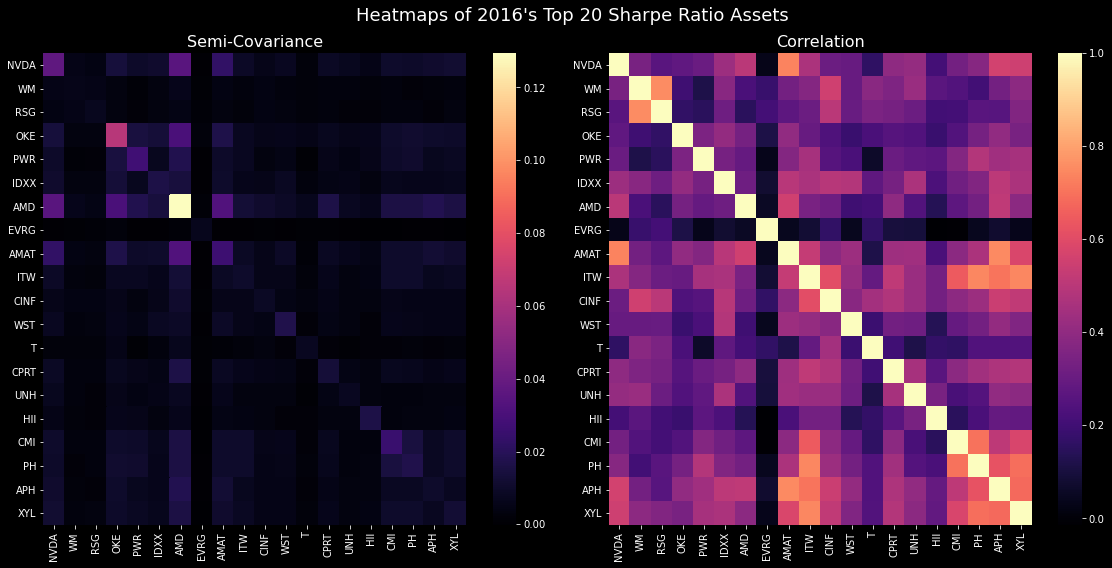

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16, 8))
fig.suptitle('Heatmaps of 2016\'s Top 20 Sharpe Ratio Assets', fontsize=18)

sns.heatmap(cov_matrix, cmap='magma',ax=ax1)
ax1.set_title('Semi-Covariance', fontsize=16)


sns.heatmap(corr_matrix, cmap='magma',ax=ax2)
ax2.set_title('Correlation', fontsize=16)


fig.tight_layout() 

plt.savefig(project_dir + '/reports/figures/' + '2016_heatmap_semi_cov_and_corr_20_sr.png')



In [22]:
cov_matrix = stocks.loc[:, stock_sym_list].pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,NVDA,WM,RSG,OKE,PWR,IDXX,AMD,EVRG,AMAT,ITW,CINF,WST,T,CPRT,UNH,HII,CMI,PH,APH,XYL
NVDA,0.000709,0.000038,0.000041,0.000051,0.000055,0.000093,0.000476,0.000012,0.000242,0.000064,0.000031,0.000074,0.000016,0.000068,0.000044,0.000049,0.000065,0.000070,0.000087,0.000068
WM,0.000038,0.000061,0.000050,0.000023,0.000027,0.000028,0.000031,0.000014,0.000031,0.000030,0.000032,0.000036,0.000022,0.000027,0.000023,0.000027,0.000029,0.000029,0.000019,0.000029
RSG,0.000041,0.000050,0.000065,0.000030,0.000037,0.000030,0.000036,0.000016,0.000040,0.000033,0.000035,0.000034,0.000022,0.000032,0.000021,0.000030,0.000032,0.000037,0.000021,0.000031
OKE,0.000051,0.000023,0.000030,0.000515,0.000135,0.000077,0.000218,0.000036,0.000096,0.000056,0.000053,0.000029,0.000053,0.000058,0.000038,0.000062,0.000096,0.000107,0.000066,0.000078
PWR,0.000055,0.000027,0.000037,0.000135,0.000251,0.000052,0.000143,0.000008,0.000076,0.000076,0.000061,0.000050,0.000024,0.000070,0.000046,0.000072,0.000111,0.000101,0.000058,0.000082
IDXX,0.000093,0.000028,0.000030,0.000077,0.000052,0.000244,0.000112,0.000010,0.000106,0.000046,0.000039,0.000077,0.000018,0.000037,0.000048,0.000039,0.000061,0.000053,0.000046,0.000030
AMD,0.000476,0.000031,0.000036,0.000218,0.000143,0.000112,0.001939,0.000007,0.000311,0.000083,0.000074,0.000088,0.000055,0.000116,0.000052,0.000060,0.000084,0.000110,0.000116,0.000106
EVRG,0.000012,0.000014,0.000016,0.000036,0.000008,0.000010,0.000007,0.000089,0.000014,0.000011,0.000011,0.000009,0.000013,0.000014,0.000009,0.000010,0.000008,0.000008,0.000007,0.000009
AMAT,0.000242,0.000031,0.000040,0.000096,0.000076,0.000106,0.000311,0.000014,0.000328,0.000072,0.000041,0.000093,0.000014,0.000068,0.000050,0.000052,0.000090,0.000083,0.000088,0.000070
ITW,0.000064,0.000030,0.000033,0.000056,0.000076,0.000046,0.000083,0.000011,0.000072,0.000095,0.000047,0.000045,0.000022,0.000048,0.000034,0.000048,0.000084,0.000085,0.000050,0.000066


In [23]:
corr_matrix = stocks.loc[:, stock_sym_list].pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,NVDA,WM,RSG,OKE,PWR,IDXX,AMD,EVRG,AMAT,ITW,CINF,WST,T,CPRT,UNH,HII,CMI,PH,APH,XYL
NVDA,1.000000,0.183147,0.191715,0.085007,0.130366,0.222563,0.406054,0.046054,0.502183,0.245974,0.110679,0.199405,0.061353,0.197595,0.156016,0.136040,0.168604,0.205730,0.358372,0.227507
WM,0.183147,1.000000,0.799518,0.129746,0.218319,0.229301,0.089474,0.188179,0.221419,0.391876,0.383717,0.333355,0.286971,0.268134,0.281751,0.254656,0.258025,0.291294,0.265948,0.331969
RSG,0.191715,0.799518,1.000000,0.165549,0.294521,0.238482,0.102520,0.211374,0.278179,0.419703,0.416950,0.304416,0.277488,0.309129,0.249863,0.273869,0.276952,0.355784,0.286250,0.346526
OKE,0.085007,0.129746,0.165549,1.000000,0.376614,0.217335,0.218598,0.169271,0.233500,0.252267,0.221195,0.092204,0.236318,0.197714,0.159568,0.202122,0.292199,0.369149,0.321155,0.303755
PWR,0.130366,0.218319,0.294521,0.376614,1.000000,0.208906,0.205042,0.050511,0.264673,0.490648,0.367342,0.228490,0.149314,0.343792,0.278583,0.333423,0.485784,0.499652,0.405448,0.461631
IDXX,0.222563,0.229301,0.238482,0.217335,0.208906,1.000000,0.162335,0.065897,0.373615,0.300376,0.235466,0.354285,0.115719,0.182945,0.291647,0.183950,0.268319,0.265778,0.321246,0.169505
AMD,0.406054,0.089474,0.102520,0.218598,0.205042,0.162335,1.000000,0.016755,0.390651,0.193610,0.158761,0.144862,0.125246,0.203677,0.112801,0.100036,0.132336,0.195419,0.290945,0.213227
EVRG,0.046054,0.188179,0.211374,0.169271,0.050511,0.065897,0.016755,1.000000,0.083407,0.121798,0.112497,0.069366,0.135493,0.114898,0.093991,0.080235,0.061550,0.066580,0.082921,0.087503
AMAT,0.502183,0.221419,0.278179,0.233500,0.264673,0.373615,0.390651,0.083407,1.000000,0.411539,0.212821,0.370636,0.078438,0.289966,0.262481,0.210331,0.342077,0.357238,0.537111,0.344859
ITW,0.245974,0.391876,0.419703,0.252267,0.490648,0.300376,0.193610,0.121798,0.411539,1.000000,0.457347,0.332550,0.223479,0.380626,0.330163,0.364960,0.595799,0.684107,0.568998,0.604431


In [24]:
w = dict(stock_cleaned_weights)
port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

0.000403421321958471

In [25]:
ind_er = stocks.loc[:, stock_sym_list].resample('BMS').last().pct_change().mean()
ind_er

NVDA    0.092195
WM      0.024068
RSG     0.021466
OKE     0.041538
PWR     0.034396
IDXX    0.037544
AMD     0.081298
EVRG    0.012108
AMAT    0.051271
ITW     0.029858
CINF    0.015287
WST     0.025912
T       0.008566
CPRT    0.043236
UNH     0.030854
HII     0.029582
CMI     0.033642
PH      0.034442
APH     0.026451
XYL     0.030340
dtype: float64

In [26]:
# Portfolio returns
w = list(w.values())
port_er = (w*ind_er).sum()
port_er

0.07024573676802683

In [27]:
ann_sd = stocks.loc[:, stock_sym_list].pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

NVDA    0.420868
WM      0.123049
RSG     0.127125
OKE     0.358721
PWR     0.250300
IDXX    0.247000
AMD     0.696229
EVRG    0.149429
AMAT    0.286193
ITW     0.153768
CINF    0.166984
WST     0.219161
T       0.157760
CPRT    0.203711
UNH     0.166047
HII     0.214888
CMI     0.229204
PH      0.202135
APH     0.143768
XYL     0.178459
dtype: float64

In [28]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets


,Returns,Volatility
NVDA,0.092195,0.420868
WM,0.024068,0.123049
RSG,0.021466,0.127125
OKE,0.041538,0.358721
PWR,0.034396,0.250300
IDXX,0.037544,0.247000
AMD,0.081298,0.696229
EVRG,0.012108,0.149429
AMAT,0.051271,0.286193
ITW,0.029858,0.153768


In [29]:
assets_c = assets.copy()
assets_c

,Returns,Volatility
NVDA,0.092195,0.420868
WM,0.024068,0.123049
RSG,0.021466,0.127125
OKE,0.041538,0.358721
PWR,0.034396,0.250300
IDXX,0.037544,0.247000
AMD,0.081298,0.696229
EVRG,0.012108,0.149429
AMAT,0.051271,0.286193
ITW,0.029858,0.153768


In [30]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(stocks.loc[:, stock_sym_list].columns)
num_portfolios = 10000000


In [ ]:
for portfolio in tqdm(range(num_portfolios)):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [ ]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(stocks.loc[:, stock_sym_list].columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [ ]:
portfolios  = pd.DataFrame(data)
portfolios # Dataframe of the 10000 portfolios created


In [ ]:
pickling_on = open(project_dir + '/data/results/' + 'random_weight_portfolio_top_20_sr_assets.pkl', 'wb')
pickle.dump(portfolios, pickling_on)
pickling_on.close()

In [31]:
pickle_off = open(project_dir + '/data/results/' + 'random_weight_portfolio_top_20_sr_assets.pkl','rb')
portfolios = pickle.load(pickle_off)


In [32]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns        0.025314
Volatility     0.095740
NVDA weight    0.003031
WM weight      0.111206
RSG weight     0.113477
OKE weight     0.009875
PWR weight     0.047917
IDXX weight    0.002096
AMD weight     0.010995
EVRG weight    0.115617
AMAT weight    0.021813
ITW weight     0.071282
CINF weight    0.028406
WST weight     0.002658
T weight       0.112417
CPRT weight    0.035356
UNH weight     0.109688
HII weight     0.072335
CMI weight     0.008070
PH weight      0.007136
APH weight     0.084857
XYL weight     0.031767
Name: 8510169, dtype: float64

In [33]:
rf = 0.00 # risk factor
sharpe_r = (portfolios['Returns']-rf)/portfolios['Volatility']

In [34]:
# Finding the optimal portfolio
optimal_risky_port = portfolios.iloc[sharpe_r.idxmax()]
optimal_risky_port

Returns        0.039225
Volatility     0.125811
NVDA weight    0.109530
WM weight      0.127407
RSG weight     0.016545
OKE weight     0.032106
PWR weight     0.017229
IDXX weight    0.098883
AMD weight     0.015926
EVRG weight    0.015782
AMAT weight    0.004461
ITW weight     0.071812
CINF weight    0.006454
WST weight     0.013039
T weight       0.000408
CPRT weight    0.125348
UNH weight     0.098909
HII weight     0.102391
CMI weight     0.002988
PH weight      0.001215
APH weight     0.027950
XYL weight     0.111615
Name: 7833970, dtype: float64

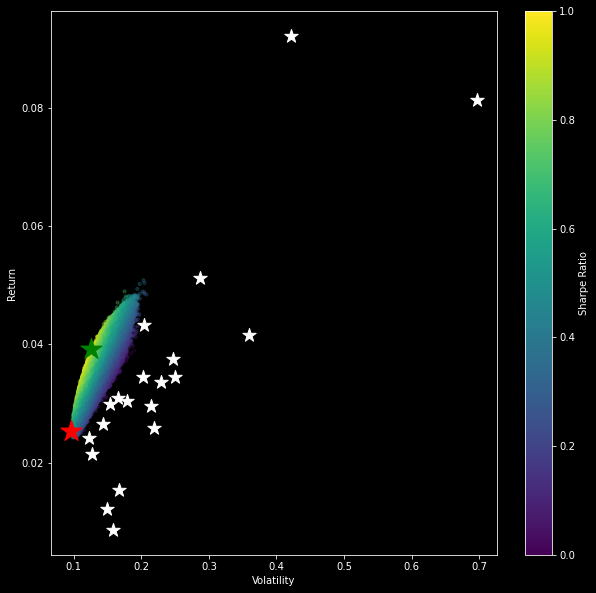

In [35]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
fig.suptitle('Efficient Frontier of 2016\'s Top 20 Sharpe Ratio Assets', fontsize=18)

plt.scatter(portfolios['Volatility'], portfolios['Returns'], c=sharpe_r, cmap='viridis', marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
plt.scatter(assets_c['Volatility'], assets_c['Returns'], color='w', marker='*', s=200)

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.savefig(project_dir + '/reports/figures/' + '2016_efficient_frontier_scatter_20_sr.png')


In [36]:
stock_cleaned_weights

OrderedDict([('NVDA', 0.55908),
             ('WM', 0.0),
             ('RSG', 0.0),
             ('OKE', 0.0),
             ('PWR', 0.0),
             ('IDXX', 0.0),
             ('AMD', 0.1909),
             ('EVRG', 0.2412),
             ('AMAT', 0.0),
             ('ITW', 0.0),
             ('CINF', 0.0),
             ('WST', 0.0),
             ('T', 0.0),
             ('CPRT', 0.0),
             ('UNH', 0.0),
             ('HII', 0.00883),
             ('CMI', 0.0),
             ('PH', 0.0),
             ('APH', 0.0),
             ('XYL', 0.0)])

In [37]:
opt_port_stock_cleaned_weights = {}
for k, v in stock_cleaned_weights.items():
    if v != 0.0:
        opt_port_stock_cleaned_weights[k] = v

opt_port_stock_list = list(opt_port_stock_cleaned_weights.keys())
opt_port_stock_cleaned_weights

{'NVDA': 0.55908, 'AMD': 0.1909, 'EVRG': 0.2412, 'HII': 0.00883}

In [38]:
opt_port_cov_matrix = stocks.loc[:, opt_port_stock_list].pct_change().apply(lambda x: np.log(1+x)).cov()
opt_port_cov_matrix

,NVDA,AMD,EVRG,HII
NVDA,0.000709,0.000476,0.000012,0.000049
AMD,0.000476,0.001939,0.000007,0.000060
EVRG,0.000012,0.000007,0.000089,0.000010
HII,0.000049,0.000060,0.000010,0.000185


In [39]:
opt_port_corr_matrix = stocks.loc[:, opt_port_stock_list].pct_change().apply(lambda x: np.log(1+x)).corr()
opt_port_corr_matrix

,NVDA,AMD,EVRG,HII
NVDA,1.000000,0.406054,0.046054,0.136040
AMD,0.406054,1.000000,0.016755,0.100036
EVRG,0.046054,0.016755,1.000000,0.080235
HII,0.136040,0.100036,0.080235,1.000000


In [40]:
opt_port_w = dict(opt_port_stock_cleaned_weights)
opt_port_port_var = opt_port_cov_matrix.mul(opt_port_w, axis=0).mul(opt_port_w, axis=1).sum().sum()
opt_port_port_var



0.00040342132195847095

In [41]:
opt_port_ind_er = stocks.loc[:, opt_port_stock_list].resample('BMS').last().pct_change().mean()
opt_port_ind_er

NVDA    0.092195
AMD     0.081298
EVRG    0.012108
HII     0.029582
dtype: float64

In [42]:
# Portfolio returns
opt_port_w = list(opt_port_w.values())
opt_port_port_er = (opt_port_w*opt_port_ind_er).sum()
opt_port_port_er

0.07024573676802681

In [43]:
opt_port_ann_sd = stocks.loc[:, opt_port_stock_list].pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
opt_port_ann_sd


NVDA    0.420868
AMD     0.696229
EVRG    0.149429
HII     0.214888
dtype: float64

In [44]:
opt_port_assets = pd.concat([opt_port_ind_er, opt_port_ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
opt_port_assets.columns = ['Returns', 'Volatility']
opt_port_assets


,Returns,Volatility
NVDA,0.092195,0.420868
AMD,0.081298,0.696229
EVRG,0.012108,0.149429
HII,0.029582,0.214888


In [45]:
opt_port_assets_c = opt_port_assets.copy()
opt_port_assets_c

,Returns,Volatility
NVDA,0.092195,0.420868
AMD,0.081298,0.696229
EVRG,0.012108,0.149429
HII,0.029582,0.214888


In [46]:
opt_port_p_ret = [] # Define an empty array for portfolio returns
opt_port_p_vol = [] # Define an empty array for portfolio volatility
opt_port_p_weights = [] # Define an empty array for asset weights

opt_port_num_assets = len(stocks.loc[:, opt_port_stock_list].columns)
opt_port_num_portfolios = 10000000

In [ ]:
for portfolio in tqdm(range(opt_port_num_portfolios)):
    opt_port_weights = np.random.random(opt_port_num_assets)
    opt_port_weights = opt_port_weights/np.sum(opt_port_weights)
    opt_port_p_weights.append(opt_port_weights)
    opt_port_returns = np.dot(opt_port_weights, opt_port_ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    opt_port_p_ret.append(opt_port_returns)
    opt_port_var = opt_port_cov_matrix.mul(opt_port_weights, axis=0).mul(opt_port_weights, axis=1).sum().sum()# Portfolio Variance
    opt_port_sd = np.sqrt(opt_port_var) # Daily standard deviation
    opt_port_ann_sd = opt_port_sd*np.sqrt(250) # Annual standard deviation = volatility
    opt_port_p_vol.append(opt_port_ann_sd)

In [ ]:
opt_port_data = {'Returns':opt_port_p_ret, 'Volatility':opt_port_p_vol}

for counter, symbol in enumerate(stocks.loc[:, opt_port_stock_list].columns.tolist()):
    #print(counter, symbol)
    opt_port_data[symbol+' weight'] = [opt_port_w[counter] for w in opt_port_p_weights]

In [ ]:
opt_port_portfolios  = pd.DataFrame(opt_port_data)
opt_port_portfolios # Dataframe of the 10000 portfolios created

In [ ]:
pickling_on = open(project_dir + '/data/results/' + 'random_weight_opt_port_portfolios_top_20_sr_assets_final_4_assets.pkl', 'wb')
pickle.dump(opt_port_portfolios, pickling_on)
pickling_on.close()

In [47]:
pickle_off = open(project_dir + '/data/results/' + 'random_weight_opt_port_portfolios_top_20_sr_assets_final_4_assets.pkl','rb')
opt_port_portfolios = pickle.load(pickle_off)

In [48]:
opt_port_min_vol_port = opt_port_portfolios.iloc[opt_port_portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
opt_port_min_vol_port

Returns        0.021842
Volatility     0.124705
NVDA weight    0.559080
AMD weight     0.190900
EVRG weight    0.241200
HII weight     0.008830
Name: 3196539, dtype: float64

In [49]:
rf = 0.00 # risk factor
opt_port_sharpe_r = (opt_port_portfolios['Returns']-rf)/opt_port_portfolios['Volatility']
# Finding the optimal portfolio
opt_port_optimal_risky_port = opt_port_portfolios.iloc[opt_port_sharpe_r.idxmax()]
opt_port_optimal_risky_port

Returns        0.045973
Volatility     0.181067
NVDA weight    0.559080
AMD weight     0.190900
EVRG weight    0.241200
HII weight     0.008830
Name: 3251720, dtype: float64

In [50]:
_opt_port_w = list(opt_port_stock_cleaned_weights.values())

_opt_port_w = _opt_port_w/np.sum(_opt_port_w)
_opt_port_returns = np.dot(_opt_port_w, opt_port_ind_er) # Returns are the product of individual expected returns of asset and its 
                                  # weights 
_opt_port_var = opt_port_cov_matrix.mul(_opt_port_w, axis=0).mul(_opt_port_w, axis=1).sum().sum()# Portfolio Variance
_opt_port_sd = np.sqrt(_opt_port_var) # Daily standard deviation
_opt_port_ann_sd = _opt_port_sd*np.sqrt(250) # Annual standard deviation = volatility

_opt_port_sharpe_r = (_opt_port_returns-rf)/_opt_port_ann_sd

In [51]:
r_opt_port_w = list(stock_raw_weights.values())
print(r_opt_port_w)

r_opt_port_w = r_opt_port_w/np.sum(r_opt_port_w)
r_opt_port_returns = np.dot(r_opt_port_w, ind_er) # Returns are the product of individual expected returns of asset and its 
                                  # weights 
r_opt_port_var = cov_matrix.mul(r_opt_port_w, axis=0).mul(r_opt_port_w, axis=1).sum().sum()# Portfolio Variance
r_opt_port_sd = np.sqrt(_opt_port_var) # Daily standard deviation
r_opt_port_ann_sd = r_opt_port_sd*np.sqrt(250) # Annual standard deviation = volatility

r_opt_port_sharpe_r = (r_opt_port_returns-rf)/r_opt_port_ann_sd

[0.5590763444683862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1908993776926035, 0.2411987290984368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0088255487405739, 0.0, 0.0, 0.0, 0.0]


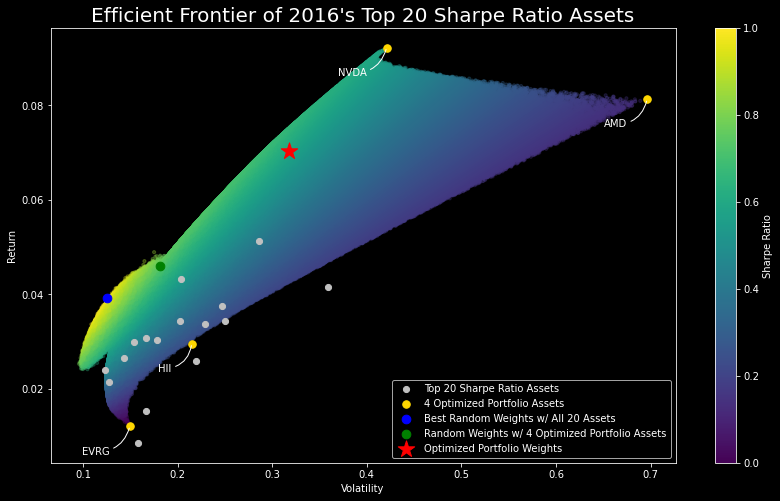

In [52]:
## Plotting optimal portfolio
plt.subplots(figsize=(14, 8))
plt.title('Efficient Frontier of 2016\'s Top 20 Sharpe Ratio Assets', fontsize=s[1])

plt.scatter(pd.concat([opt_port_portfolios['Volatility'], portfolios['Volatility']]), pd.concat([opt_port_portfolios['Returns'], portfolios['Returns']]), c=pd.concat([opt_port_sharpe_r, sharpe_r]), cmap='viridis', marker='o', s=10, alpha=0.3)
plt.scatter(assets_c['Volatility'], assets_c['Returns'], color='silver', marker='.', s=150, label='Top 20 Sharpe Ratio Assets')
plt.scatter(opt_port_assets_c['Volatility'], opt_port_assets_c['Returns'], color='gold', marker='.', s=225, label='4 Optimized Portfolio Assets')



for label, x, y in zip(opt_port_assets_c.index, opt_port_assets_c['Volatility'], opt_port_assets_c['Returns']):
#     ry = random.randint(10,100)
    plt.annotate(label, xy=(x, y), xytext=(-20, -30), textcoords='offset points', ha='right', va='bottom',
    arrowprops=dict(arrowstyle='-', color='w', connectionstyle='arc3, rad=0.4'))


plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='b', marker='.', s=300, label='Best Random Weights w/ All 20 Assets')
plt.scatter(opt_port_optimal_risky_port[1], opt_port_optimal_risky_port[0], color='g', marker='.', s=300, label='Random Weights w/ 4 Optimized Portfolio Assets')
plt.scatter(_opt_port_ann_sd, _opt_port_returns, color='r', marker='*', s=300, label='Optimized Portfolio Weights')


plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.legend(loc="lower right")


plt.savefig(project_dir + '/reports/figures/' + '2016_efficient_frontier_scatter_20_sr_optimized_portfolio.png')


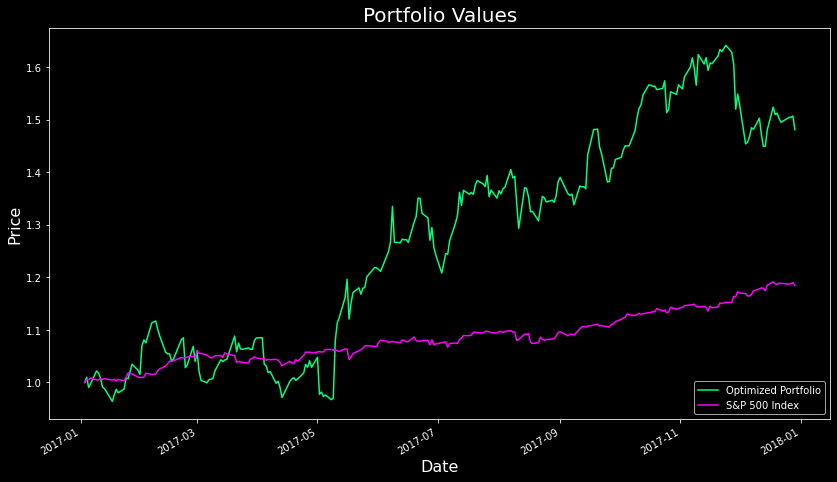

In [53]:

stock_allocs = pd.DataFrame({'cleaned_weights': stock_cleaned_weights}, index=w_stock_prices.columns)['cleaned_weights'].to_list()
index_allocs = 1  

stock_e_price = stocks.loc[ed:ed+dd, stock_sym_list]
index_e_price = sp500_index_adj_close_df.loc[ed:ed+dd, index_sym_list]

stock_pv = get_daily_portfolio_values(stock_e_price, stock_allocs, sv=sv)
index_pv = get_daily_portfolio_values(index_e_price, index_allocs, sv=sv)


# Build plot figure
fig, ax = plt.subplots(1, figsize=(14, 8))

# Plot the results
stock_pv.plot(kind='line', ax=ax, c=c[1], label='Optimized Portfolio')
index_pv.plot(kind='line', ax=ax, c=c[2], label='S&P 500 Index')

ax.set_title(f"Portfolio Values", fontsize=s[1])
ax.set_xlabel(f"Date", fontsize=s[2])
ax.set_ylabel(f"Price", fontsize=s[2])
ax.legend(loc="lower right")


plt.savefig(project_dir + '/reports/figures/' + '2016_portfolio_value.png')


In [54]:
stock_pv[-1]

1.480961210098454

In [55]:
index_pv[-1]

1.1841502747815977